In [2]:
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage import exposure, color
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
import matplotlib.patches as patches


In [3]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

In [4]:
def extract_features(img_path, model):
    img = load_and_preprocess_image(img_path)
    img = np.expand_dims(img, axis=0)
    features = model.predict(img)
    return features

In [5]:
def model_creation():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    return base_model

In [6]:
res_model = model_creation()
res_model.summary()

80134624/80134624 [==============================] - 34s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [7]:
def detect_differences1(image1_path, image2_path, threshold=0.3):
    # Assuming you have a function extract_features defined
    features1 = extract_features(image1_path, res_model)
    features2 = extract_features(image2_path, res_model)

    # Calculate the absolute difference between the feature maps
    difference_map = np.abs(features1 - features2)

    # Sum along the channel axis to obtain a single-channel difference map
    difference_map = np.sum(difference_map, axis=-1)

    difference_map = exposure.rescale_intensity(difference_map, in_range='image', out_range=(0, 1))

    # Binarize the difference map using a threshold
    binary_difference_map = (difference_map > threshold).astype(np.uint8)

    # Find contours in the binary difference map using RETR_EXTERNAL mode
    contours, _ = cv2.findContours(binary_difference_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Display the images with bounding boxes
    img1 = cv2.cvtColor(cv2.imread(image1_path), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(image2_path), cv2.COLOR_BGR2RGB)

    img_with_boxes = img1.copy()

    for contour in contours:
        # Draw bounding box around the contour
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 0, 0), 2)

    # Display the images with bounding boxes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img1)
    axes[0].set_title('Image 1')

    axes[1].imshow(img2)
    axes[1].set_title('Image 2')

    axes[2].imshow(img_with_boxes)
    axes[2].set_title('Differences Detection')

    plt.show()

In [11]:
# Specify the paths to your images
image1_path = 'E:/data science/Website/images/input1.png'
image2_path = 'E:/data science/Website/images/input2.png'

detect_differences1(image1_path, image2_path)

ValueError: in user code:

    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\dibya\anaconda3\envs\website\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vgg19" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 1, 224, 224, 3)


***

In [9]:
import cv2
import imutils
import numpy as np


In [17]:
def detect_differences2(img1, img2):
  img1 = cv2.imread(img1)
  img2 = cv2.imread(img2)

  print(img1.shape)
  print(img2.shape)

  img1 = cv2.resize(img1, (428, 926))
  img2 = cv2.resize(img2, (428, 926))

  max_height = max(img1.shape[0], img2.shape[0])
  print(max_height)

  gr1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gr2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  diff = cv2.absdiff(gr1, gr2)
  #plt.subplot(131), plt.imshow(diff), plt.title("diff [im1, im2]")
  Score = np.mean(diff)
  print("Similarity Score is: ", Score)

  thres = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  plt.subplot(131), plt.imshow(thres), plt.title("Threshold")

  #dilation
  kernel = np.ones((5, 5), np.uint8)
  dilate = cv2.dilate(thres, kernel, iterations=2)
  plt.subplot(132), plt.imshow(dilate), plt.title("dilate")

  #Contour
  contours = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(contours)

  #loop over each contourse
  for contour in contours:
    if cv2.contourArea(contour) > 100:
      x, y, w, h = cv2.boundingRect(contour)

      ## draw bounding boxes
      cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 2)
      cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)

  ## results
  plt.figure(figsize=(30, 15))
  x = np.zeros((max_height, 10, 3), np.uint8)
  res = np.hstack((img1, x, img2))
  plt.subplot(133), plt.imshow(res, cmap="coolwarm"), plt.title("Result")
  plt.show()


(926, 428, 3)
(926, 428, 3)
926
Similarity Score is:  3.7766193657778406


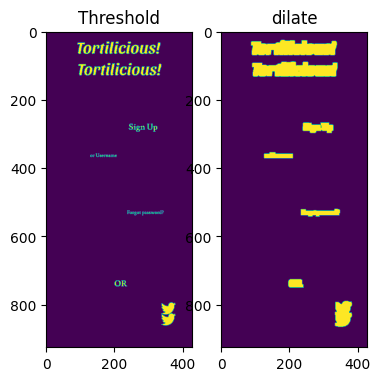

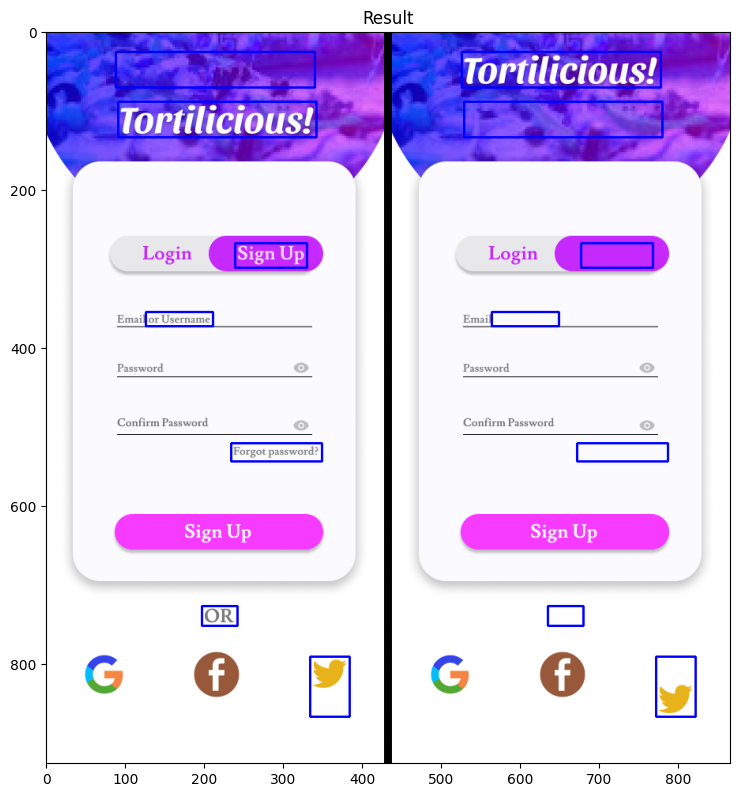

In [18]:
image1_path = 'E:/data science/Website/images/input1.png'
image2_path = 'E:/data science/Website/images/input2.png'

detect_differences2(image1_path, image2_path)

***

In [13]:
from skimage.metrics import structural_similarity as ssim
from skimage import io, color
import matplotlib.pyplot as plt

In [14]:
def draw_bounding_boxes(image, contours):
    img_with_boxes = image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 0, 255), 2)
    return img_with_boxes


In [20]:
def detect_differences3(image1_path, image2_path, threshold=0.3):
    # Load images in BGR format (default for cv2.imread)
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Convert BGR to RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Convert images to grayscale
    img1_gray = color.rgb2gray(img1)
    img2_gray = color.rgb2gray(img2)

    # Calculate Structural Similarity Index (SSI)
    ssim_index, _ = ssim(img1_gray, img2_gray, full=True, data_range=img2_gray.max() - img2_gray.min())

    print("SSI Index:", ssim_index)

    # Set a threshold for differences
    if ssim_index > threshold:
        print("Images are different!")

        # Calculate absolute difference between images
        difference_map = np.abs(img1_gray - img2_gray)

        # Additional preprocessing steps
        difference_map = cv2.GaussianBlur(difference_map, (5, 5), 0)
        difference_map = cv2.morphologyEx(difference_map, cv2.MORPH_CLOSE, kernel=np.ones((5, 5), np.uint8))

        # Binarize the difference map using a threshold
        binary_difference_map = (difference_map > threshold).astype(np.uint8)

        # Find contours in the binary difference map using RETR_EXTERNAL mode
        contours, _ = cv2.findContours(binary_difference_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the images
        img1_with_boxes = draw_bounding_boxes(img1, contours)
        img2_with_boxes = draw_bounding_boxes(img2, contours)

        # Display the images with bounding boxes
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img1_with_boxes)
        axes[0].set_title('Image 1 with Bounding Boxes')

        axes[1].imshow(img2_with_boxes)
        axes[1].set_title('Image 2 with Bounding Boxes')

        axes[2].imshow(img1_gray - img2_gray, cmap='coolwarm', vmin=-1, vmax=1)
        axes[2].set_title('Differences Detection')

        plt.show()
    else:
        print("Images are similar!")

SSI Index: 0.9386918007861362
Images are different!


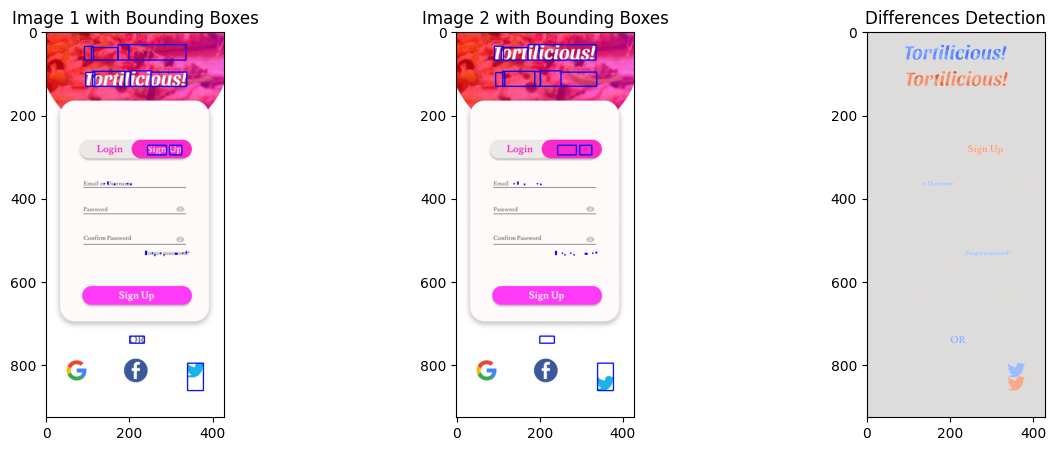

In [21]:
# Specify the paths to your images
image1_path = 'E:/data science/Website/images/input1.png'
image2_path = 'E:/data science/Website/images/input2.png'

detect_differences3(image1_path, image2_path)